<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/03_CLARA_KMEDOID_materials_extracted_colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kneed
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.9 MB/s eta 0:00:00


In [ ]:
from unicodedata import normalize


import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

# Estandarizacion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Metrica
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator

# Cluster
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.decomposition import PCA


import warnings

# **Información**

## **Datos**

---
Mineria - Materiales extraidos en Colombia 2012 a 2017

Información detallada de la cantidad de mineral extraído en el territorio nacional, asociando a la contraprestación económica generada por municipio productor desde la vigencia 2012 a la vigencia actual.

**Información de la Entidad**
- Área o dependencia:	Grupo de Regalías y Contraprestaciones Económicas.
- Nombre de la Entidad:	Agencia Nacional de Minería
- Departamento:	Bogotá D.C.
- Municipio:	Bogotá D.C.
- Orden:	Nacional
- Sector:	Minas y Energía

**Información de Datos**
- Idioma:	Español
- Cobertura Geográfica:	Nacional
- Frecuencia de Actualización:	Trimestral
- Fecha Emisión: (aaaa-mm-dd)	2017-10-27


**Notas Aclaratorias:**

• Los datos que se presentan son preliminares de acuerdo con la información que la Agencia Nacional de Minería ha recibido de parte de los titulares mineros, exportadores o agentes retenedores a la fecha de publicación, la información presentada se reportara de forma dinámica en la medida que los consolidados recibidos y tramitados afecten trimestres anteriores o vigencias anteriores.

• Producción de esmeraldas, esta se tiene desde de octubre de 2016 ya que solo con la implementación del RUCOM se ha podido obtener información del origen de este recurso mineral; con anterioridad sólo se obtenía información en el momento de la comercialización o exportación de estas y en consecuencia se refería como origen la ciudad de Bogotá, lugar de exportación.

• Producción de Metales preciosos (Oro, Plata, y Platino), la unidad de medida utilizada en la presentación de estos datos es el gramo, unidad que reportan en sus declaraciones los titulares mineros o exportadores para la liquidación de las regalías e impuestos correspondiente. Sin embargo, la unidad que se maneja de manera estadística a nivel nacional o internacional es la onza troy la cual equivale a 31,1034768 gramos.

• La compensación es una contraprestación económica que se fija contractualmente y que no corresponde a una producción de mineral.

**Última Actualización**: 18 de septiembre de 2023

**Suministró los datos**: Fondo Nacional de Garantías S.A.AGENCIA NACIONAL DE MINERÍA

**path data**: https://www.datos.gov.co/Minas-y-Energ-a/Mineria-Materiales-extraidos-en-Colombia-2012-a-20/95e9-vx89


---
## **Proceso**

**Proposito**

- Construir un modelo con la capacidad de segmentar aquellos municipios acorde a sus características de explotación del recurso minero.
- Investigar e implementar el modelo K medoid CLARA



**Aspectos**

- Para cuestiones del ejercicio tomaremos los últimos cinco años.
- Se utilizará el modelo k-medoid y sus variaciones. Es posible que otros modelos sean mejores, pero el enfoque del proyecto también es el uso del k-meadoid y de sus variantes.


**El factor a segmentar**:
- municipio.

**Diccionario de datos**
No se dispone de un diccionario bien definido, pero se interpreta la data y el conocimiento general.

- Municipio Productor: Municipio donde se extrae el recurso
- Departamento: Departamento donde se extrae el recurso
- Recurso Natural: Recurso natural que se extrae
- Nombre Del Proyecto: Nombre del proyecto, organización o conglomerado de extracción del recurso
- Año Produccion: Año de la extracción
- Trimestre: Trimestre de la extracción
- Unidad Medida: Medida la cantidad producción
- Tipo Contraprestacion: Si es compensación o regalia
- Valor Contraprestacion: Valor de la contraprestación
- Cantidad Producción: Cantidad producida

# **Funciones**
---

In [ ]:
def normalize_word(word):
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

def componentes_principales(data:object,
                            min_explained_variance:int=0.85,
                            min_component:int=3,
                            **kwards)->tuple:
  """simple method of PCA, that return data transform"""
  final_comp = 0
  for comp in range(min_component, data.shape[1]):
    pca = PCA(n_components=comp, **kwards)
    pca.fit(data)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() >= min_explained_variance:
      break

  final_pca = PCA(n_components=final_comp, **kwards)
  final_pca.fit(data)
  data_df = final_pca.transform(data)
  info = "Using {} components, we can explain {}% of the variability\
  in the original data.".format(final_comp,comp_check.sum())

  return data_df, final_pca, info


def plot_select_params(scores, x_params, **kwards):

  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores, marker='o')



  keis = []
  if kwards:
    keis = kwards.keys()


  #if 'best_cluster' in keis:
    #best_x_param = kwards['best_x_param']
    #print(kwards['best_cluster'])

    #ax.plot(best_x_param, best_score, marker='o', color='r')
    #ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])


def silhouette_select_cluster(
    model,
    clusters,
    data,
    kneedle=False,
    pl=True,
    **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg

  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())

  extra_params = dict()

  if kneedle:
    kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")
    best_score = valores_medios_silhouette[kneedle.elbow]
    best_cluster = kneedle.elbow
    extra_params['best_score'] = best_score
    extra_params['best_cluster'] = best_cluster

  title = f'Evolución de media de los índices silhouette {kwards["name_model"]}'
  ylabel = 'Media índices silhouette'
  xlabel = 'Numero clusters'

  extra_params['title'] = title
  extra_params['ylabel'] = ylabel
  extra_params['xlabel'] = xlabel

  if pl:
    plot_select_params(
        y,
        range_n_clusters,
        **extra_params
    )

  res_data = {
      'score': y,
  }
  return res_data

  #return best_cluster, best_score
# silhouette_select_cluster(fcm, (2,5), cluster_df, name_model = 'FUzzy')

def visulization_silhouette(data, y_predict, name, colores):
  """Visualiza el coeficiente de silhouette"""
  silhouette_avg=silhouette_score(data, y_predict)
  sample_silhouette_values = silhouette_samples(data, y_predict)
  y_lower = 5
  fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
  n_clusters = np.unique(y_predict).shape[0]
  ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
  for i in np.unique(y_predict):

    # Agregue las puntuaciones de silueta para muestras pertenecientes a
    # agrupe i, y ordénelos
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    try:
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colores[i], edgecolor=colores[i], alpha=0.7)
    except:
      pass
    # Etiquete las parcelas de silueta con sus números de grupo en el medio
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule el nuevo y_lower para la siguiente parcela
    y_lower = y_upper + 10  # 10 para las 0 muestras
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")
  plt.suptitle((f"Silhouette analysis for {name} clustering on sample data "
                  f"with n_clusters = {n_clusters}" ),
                 fontsize=14, fontweight='bold')

# **Config**
---

In [ ]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Materiales extraídos en los municipios en Colombia'
paleta = sns.color_palette("tab10").as_hex()
warnings.filterwarnings("ignore")
random_seedd = 73

# **Data**
---

In [ ]:
url_materiales_mineros = 'https://drive.google.com/file/d/1Ff0yiGG1mlmV_cIZjdSzXrQu1Xdn6CFM/view?usp=sharing'
url_materiales_mineros = 'https://drive.google.com/uc?id=' + url_materiales_mineros.split('/')[-2]
data_materiales_mineros = pd.read_csv(url_materiales_mineros, dtype='str')

Normalización de los nombres de las columnas

In [ ]:
data_materiales_mineros.columns = normalize_name_columns(
    data_materiales_mineros.columns)

- Se asigna los tipos de datos reales a los datos

In [ ]:
data_materiales_mineros.head(3)

,municipio_productor,departamento,recurso_natural,nombre_del_proyecto,ano_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381
2,Medellin,Antioquia,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,Trimestre 1,TONELADAS,REGALIAS,836927,16308


In [ ]:
data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]] = data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]].astype('float64')

- Se transforma una columna trimestre de texto a número

In [ ]:
data_materiales_mineros[
    'trimestre'] = data_materiales_mineros[
        'trimestre'].apply(lambda x: x.split(' ')[1])

data_materiales_mineros

,municipio_productor,departamento,recurso_natural,nombre_del_proyecto,ano_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,4,TONELADAS,REGALIAS,"614,258.00",0.00
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,4,TONELADAS,REGALIAS,"2,036,781.00","14,381.00"
2,Medellin,Antioquia,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,1,TONELADAS,REGALIAS,"836,927.00","16,308.00"
3,Medellin,Antioquia,ARCILLAS MISCELANEAS,PRODUCTORES,2019,1,TONELADAS,REGALIAS,"5,763,839.00","33,348.00"
4,Medellin,Antioquia,ARCILLAS MISCELANEAS,PRODUCTORES,2022,1,TONELADAS,REGALIAS,"7,187,998.00","28,540.00"
...,...,...,...,...,...,...,...,...,...,...
55252,Cumaribo,Vichada,TANTALIO,PRODUCTORES,2018,2,KILOGRAMOS,REGALIAS,"645,095.00",35.00
55253,Cumaribo,Vichada,ORO,PRODUCTORES,2019,4,GRAMOS,REGALIAS,"9,251,843.00","1,752.00"
55254,Cumaribo,Vichada,NIOBIO,PRODUCTORES,2014,4,KILOGRAMOS,REGALIAS,"23,396,026.00","6,195.00"
55255,Cumaribo,Vichada,NIOBIO,PRODUCTORES,2016,4,KILOGRAMOS,REGALIAS,"12,658,396.00","1,442.00"


In [ ]:
data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]] = data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]].astype('int32')

Se tomará como periodo de datos para el entrenamiento de modelos 5 años

In [ ]:
data_materiales_mineros = data_materiales_mineros[
    (data_materiales_mineros["ano_produccion"] >= 2018)
    &
    (data_materiales_mineros["ano_produccion"] < 2023)
    ]

**Movimiento Transacciones**

In [ ]:
function_dictionary = {
    "valor_contraprestacion": ['sum', 'count']
}

filter_feature = [
    'departamento',
    'municipio_productor',
    'ano_produccion',
    'trimestre']

new_val_col = [
    'valor_contraprestacion',
    'conteo_transacciones'
]


data_group = data_materiales_mineros.groupby(
    filter_feature).aggregate(function_dictionary)

data_group.columns = new_val_col
data_group = data_group.reset_index()

data_group

,departamento,municipio_productor,ano_produccion,trimestre,valor_contraprestacion,conteo_transacciones
0,Antioquia,Abejorral,2018,1,"2,783,489.00",1
1,Antioquia,Abejorral,2018,2,"3,659,452.00",1
2,Antioquia,Abejorral,2018,3,"5,732,763.00",1
3,Antioquia,Abejorral,2018,4,"11,706,438.00",2
4,Antioquia,Abejorral,2019,1,"5,793,131.00",2
...,...,...,...,...,...,...
9166,Vichada,Puerto Carreño,2021,2,"360,000.00",1
9167,Vichada,Puerto Carreño,2021,3,"190,000.00",1
9168,Vichada,Puerto Carreño,2021,4,"460,000.00",1
9169,Vichada,Puerto Carreño,2022,3,"240,000.00",1


In [ ]:
function_dictionary = {
    'valor_contraprestacion': ['sum', 'mean'],
    'conteo_transacciones': ['sum', 'mean'],
    'trimestre':['count'],
    'ano_produccion':['nunique']
}

filter_feature = [
    'departamento',
    'municipio_productor'
]

new_val_col = [
    'valor_contraprestacion_total',
    'valor_contraprestacion_promedio',
    'conteo_transacciones_totales',
    'conteo_transacciones_totales_promedio',
    'numero_trimestres_activos',
    'ano_produccion_activo'
]

data_group = data_group.groupby(
    filter_feature).aggregate(function_dictionary)

data_group.columns = new_val_col
data_group = data_group.reset_index()

data_group

,departamento,municipio_productor,valor_contraprestacion_total,valor_contraprestacion_promedio,conteo_transacciones_totales,conteo_transacciones_totales_promedio,numero_trimestres_activos,ano_produccion_activo
0,Antioquia,Abejorral,"52,580,674.00","4,780,061.27",17,1.55,11,4
1,Antioquia,Abriaqui,"355,266,722.00","23,684,448.13",35,2.33,15,5
2,Antioquia,Amaga,"3,393,763,652.00","169,688,182.60",51,2.55,20,5
3,Antioquia,Amalfi,"8,572,556,923.00","428,627,846.15",79,3.95,20,5
4,Antioquia,Andes,"2,699,326,802.00","179,955,120.13",31,2.07,15,4
...,...,...,...,...,...,...,...,...
701,Valle del Cauca,Yumbo,"1,418,565,626.00","70,928,281.30",108,5.40,20,5
702,Valle del Cauca,Zarzal,"12,268,845.00","766,802.81",20,1.25,16,5
703,Vaupes,Mitu,"87,841,688.00","29,280,562.67",8,2.67,3,3
704,Vichada,Cumaribo,"9,896,938.00","4,948,469.00",2,1.00,2,2


Una vez obtenido las variables transacciones se procede a realizar un proceso de análisis, si bien es posible utilizar el resto de información no transaccional o agrupados por otras variables, por efectos del ejercicio me quedaré con los montos transaccionales.

- Validaciones de municipio con nombre similares, para evitar este caso, se agrupó con departamentos.

In [ ]:
data_group['municipio_productor'].duplicated().sum()

0

# **SPLit**
---

In [ ]:
columnas = [
    'valor_contraprestacion_promedio',
    'conteo_transacciones_totales_promedio',
    'numero_trimestres_activos',
    'ano_produccion_activo']

In [ ]:
X_train = data_group[columnas]

In [ ]:
X_train

,valor_contraprestacion_promedio,conteo_transacciones_totales_promedio,numero_trimestres_activos,ano_produccion_activo
0,"4,780,061.27",1.55,11,4
1,"23,684,448.13",2.33,15,5
2,"169,688,182.60",2.55,20,5
3,"428,627,846.15",3.95,20,5
4,"179,955,120.13",2.07,15,4
...,...,...,...,...
701,"70,928,281.30",5.40,20,5
702,"766,802.81",1.25,16,5
703,"29,280,562.67",2.67,3,3
704,"4,948,469.00",1.00,2,2


# **EDA**
---

In [ ]:
estimator = MinMaxScaler()
estimator.fit(X_train)
data_estandarizada = estimator.transform(X_train)

In [ ]:
data_estandarizada

array([[1.31351178e-05, 5.24475524e-02, 5.26315789e-01, 7.50000000e-01],
       [6.50826002e-05, 1.28205128e-01, 7.36842105e-01, 1.00000000e+00],
       [4.66287171e-04, 1.49038462e-01, 1.00000000e+00, 1.00000000e+00],
       ...,
       [8.04601982e-05, 1.60256410e-01, 1.05263158e-01, 5.00000000e-01],
       [1.35978865e-05, 0.00000000e+00, 5.26315789e-02, 2.50000000e-01],
       [5.41427857e-06, 3.60576923e-02, 7.89473684e-01, 1.00000000e+00]])

In [ ]:
data_df, final_pca, info = componentes_principales(
    data_estandarizada,
    min_component=3,
    random_state = random_seedd
)

In [ ]:
pdata_3 = pd.DataFrame(data_df, columns = ['pc1', 'pc2', 'pc3'])
pdata_3

,pc1,pc2,pc3
0,0.10,-0.07,-0.00
1,-0.23,-0.08,0.05
2,-0.43,0.07,-0.06
3,-0.44,0.15,0.04
4,-0.06,0.06,-0.07
...,...,...,...
701,-0.46,0.23,0.15
702,-0.26,-0.11,-0.06
703,0.56,-0.07,0.19
704,0.79,-0.03,0.00


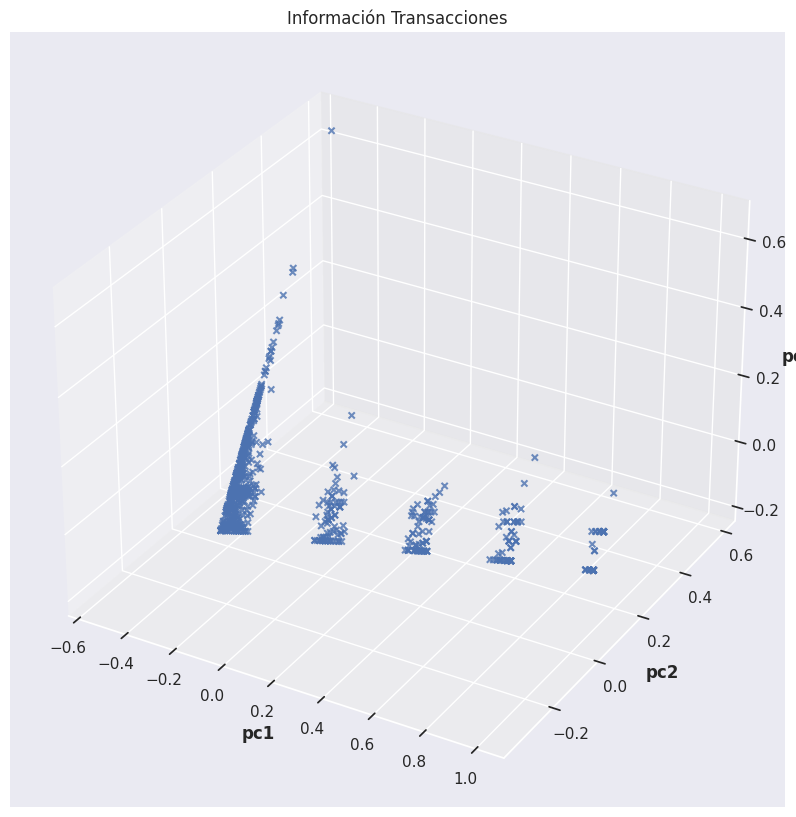

In [ ]:
fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection ="3d")

x=pdata_3['pc1']
y=pdata_3['pc2']
z=pdata_3['pc3']

my_cmap = plt.get_cmap('tab10')

sctt = ax.scatter3D(
    x,
    y,
    z,
    alpha = 0.8,

    cmap = my_cmap,
    marker ='x')


plt.title("Información Transacciones")
ax.set_xlabel('pc1', fontweight ='bold')
ax.set_ylabel('pc2', fontweight ='bold')
ax.set_zlabel('pc3', fontweight ='bold')

plt.show()

In [ ]:
data_df, final_pca, info = componentes_principales(
    data_estandarizada,
    min_component=2,
    random_state = random_seedd
)

In [ ]:
data_df

array([[ 0.09698803, -0.07353105],
       [-0.23477381, -0.07958786],
       [-0.42549678,  0.06600278],
       ...,
       [ 0.55742484, -0.06645836],
       [ 0.7863327 , -0.02996465],
       [-0.26142111, -0.10697836]])

In [ ]:
pdata = pd.DataFrame(data_df, columns = ['pc1', 'pc2'])
pdata

,pc1,pc2
0,0.10,-0.07
1,-0.23,-0.08
2,-0.43,0.07
3,-0.44,0.15
4,-0.06,0.06
...,...,...
701,-0.46,0.23
702,-0.26,-0.11
703,0.56,-0.07
704,0.79,-0.03


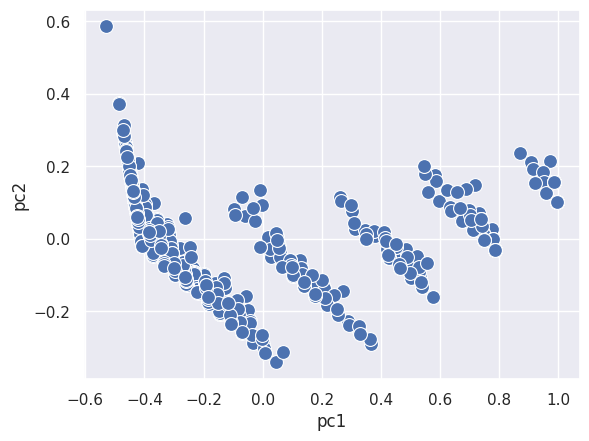

In [ ]:
sns.scatterplot(
    data=pdata,
    x = 'pc1',
    y= 'pc2',
    palette= paleta,
    s= 100 )
plt.show()

- Con la reducción a tres y dos dimensiones , se puede validar que la data se puede dividir en conjuntos separables.

# **Kmedoid Alternative**
---

In [ ]:
model = KMedoids(
    metric='euclidean',
    method='alternate',
    init = 'heuristic',
    max_iter=300,
    random_state=random_seedd
)
kmedoid_init_heuristic = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "k-medoids++"
kmedoid_init_kmedoid_plus  = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "build"
kmedoid_init_kmedoid_build  = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "random"
kmedoid_init_kmedoid_random = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

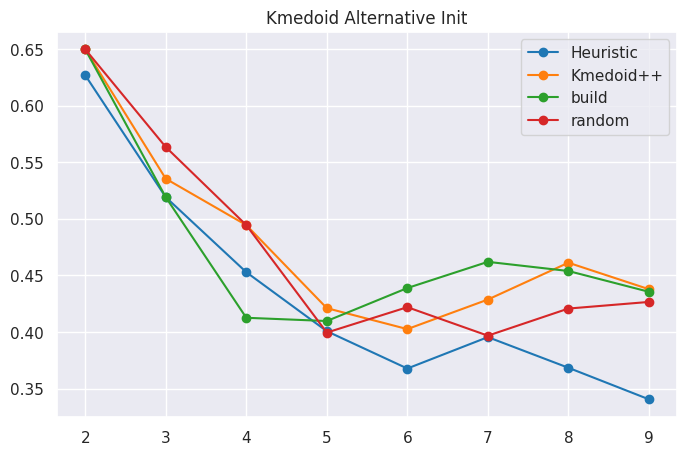

In [ ]:
range_cluster = list(range(2, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    range_cluster,
    kmedoid_init_heuristic['score'],
    marker='o',
    label='Heuristic',
    color=paleta[0])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_plus['score'],
    marker='o',
    label='Kmedoid++',
    color=paleta[1])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_build['score'],
    marker='o',
    label='build',
    color=paleta[2])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_random['score'],
    marker='o',
    label='random',
    color=paleta[3])


plt.title('Kmedoid Alternative Init')
plt.legend()
plt.show()

Como se evidencia en la gráfica, la inicialización de los meoids con mejor comportamiento es el kmedoid++ en la mayoria de iteraciones. Buil mejora el las ultimas iteraciones, random reduce su interación a medida que avanzan las iteraciones.

# **Kmedoid PAM**
---

In [ ]:
model = KMedoids(
    metric='euclidean',
    method='pam',
    init = 'heuristic',
    max_iter=300,
    random_state=random_seedd
)
kmedoid_init_heuristic = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "k-medoids++"
kmedoid_init_kmedoid_plus  = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "build"
kmedoid_init_kmedoid_build  = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

In [ ]:
model.init = "random"
kmedoid_init_kmedoid_random = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'Kmedoid')

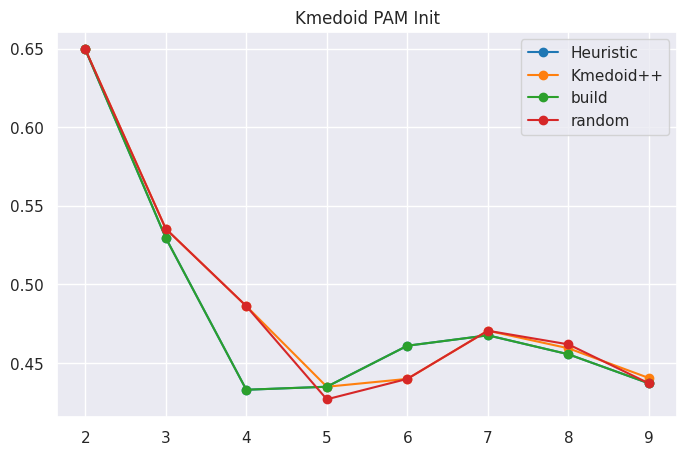

In [ ]:
range_cluster = list(range(2, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    range_cluster,
    kmedoid_init_heuristic['score'],
    marker='o',
    label='Heuristic',
    color=paleta[0])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_plus['score'],
    marker='o',
    label='Kmedoid++',
    color=paleta[1])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_build['score'],
    marker='o',
    label='build',
    color=paleta[2])

ax.plot(
    range_cluster,
    kmedoid_init_kmedoid_random['score'],
    marker='o',
    label='random',
    color=paleta[3])


plt.title('Kmedoid PAM Init')
plt.legend()
plt.show()

Con el método PAM es la variante más voraz, pero más precisa que la versión alternativa, los scors de los coeficientes no permiten ver una diferencia significativa. Otro aspecto es que los coeficientes en su gran mayoría están en un rango superior al 0.45. Se podría decir que entre los primeros clústeres el que mejor tiene comportamiento es la inicialización Random, kmedoid ++ y el Heuristic.

# **CLARA**
---

Unknown metric euclidea. Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'nan_euclidean', 'haversine'], or 'precomputed', or a callable

In [ ]:
model = CLARA(
    max_iter=300,
    metric='euclidean',
    init = 'build',
    n_sampling_iter=75,
    random_state=random_seedd
)

model_clara_build_score = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'CLARA')

model.init = 'random'
model_clara_random_score = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'CLARA')

model.init = 'k-medoids++'
model_clara_plus_score = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'CLARA')

model.init = 'heuristic'
model_clara_heuristic_score = silhouette_select_cluster(
    model,
    (2,10),
    data_estandarizada,
    kneedle = True,
    pl = False,
    name_model = 'CLARA')



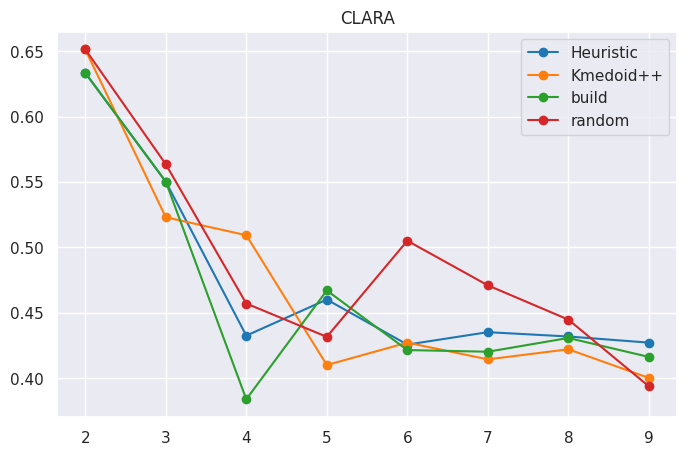

In [ ]:
range_cluster = list(range(2, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    range_cluster,
    model_clara_heuristic_score['score'],
    marker='o',
    label='Heuristic',
    color=paleta[0])

ax.plot(
    range_cluster,
    model_clara_plus_score['score'],
    marker='o',
    label='Kmedoid++',
    color=paleta[1])

ax.plot(
    range_cluster,
    model_clara_build_score['score'],
    marker='o',
    label='build',
    color=paleta[2])

ax.plot(
    range_cluster,
    model_clara_random_score['score'],
    marker='o',
    label='random',
    color=paleta[3])


plt.title('CLARA')
plt.legend()
plt.show()

Se valida el número de segmentos donde las inicializaciones concuerdan

# **Modelos definitivos**

In [ ]:
model_alternativo_plusplus = KMedoids(
    n_clusters=6,
    metric='euclidean',
    method='alternate',
    init = 'k-medoids++',
    max_iter=300,
    random_state=random_seedd
)

model_alternativo_plusplus.fit(data_estandarizada)
y_predict_alternativo_plusplus = model_alternativo_plusplus.predict(data_estandarizada)
values_alternative = pd.Series(y_predict_alternativo_plusplus).value_counts().sort_index()
names_alternative = values_alternative.index
values_alternative = values_alternative.values
score_alternativo_plusplus = silhouette_score(data_estandarizada, y_predict_alternativo_plusplus)

In [ ]:
model_pam_plusplus = KMedoids(
    n_clusters=5,
    metric='euclidean',
    method='pam',
    init = 'k-medoids++',
    max_iter=300,
    random_state=random_seedd
)

model_pam_plusplus.fit(data_estandarizada)
y_predict_pam_plusplus = model_pam_plusplus.predict(data_estandarizada)
values_pam = pd.Series(y_predict_pam_plusplus).value_counts().sort_index()
names_pam = values_pam.index
values_pam = values_pam.values
score_pam_plusplus = silhouette_score(data_estandarizada, y_predict_pam_plusplus)

In [ ]:
model_clara = CLARA(
    n_clusters=6,
    max_iter=300,
    metric='euclidean',
    init = 'random',
    n_sampling_iter=75,
    random_state=random_seedd
)

model_clara.fit(data_estandarizada)
y_predict_clara_build = model_clara.predict(data_estandarizada)
values_clara = pd.Series(y_predict_clara_build).value_counts().sort_index()
names_clara = values_clara.index
values_clara = values_clara.values
score_clara_build = silhouette_score(data_estandarizada, y_predict_clara_build)

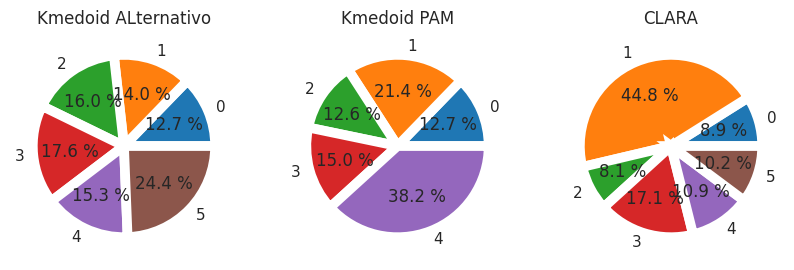

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].pie(
    values_alternative,
    labels=names_alternative,
    autopct="%0.1f %%",
    wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
    colors = paleta)
ax[0].set_title('Kmedoid ALternativo')
ax[1].pie(
    values_pam,
    labels=names_pam,
    autopct="%0.1f %%",
    wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
    colors = paleta)
ax[1].set_title('Kmedoid PAM')

ax[2].pie(
    values_clara,
    labels=names_clara,
    autopct="%0.1f %%",
    wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
    colors = paleta)
ax[2].set_title('CLARA')
plt.show()

In [ ]:
print(f'Score Alternativo {score_alternativo_plusplus}')
print(f'Score PAM {score_pam_plusplus}')
print(f'Score CLARA {score_clara_build}')

Score Alternativo 0.40265691800683956
Score PAM 0.434869668702556
Score CLARA 0.5050098275671596


- El modelo que tiene el mejor comportamiento es CLARA con un score de 0.52. Los modelos alternativo y PAM tienen un comportamiento similar.

In [ ]:
pdata['segment_clara'] = y_predict_clara_build
pdata['segment_pam'] = y_predict_pam_plusplus
pdata['segment_alternative'] = y_predict_alternativo_plusplus

In [ ]:
pdata_3['segment_clara'] = y_predict_clara_build
pdata_3['segment_pam'] = y_predict_pam_plusplus
pdata_3['segment_alternative'] = y_predict_alternativo_plusplus

In [ ]:
data_group['segment_clara'] = y_predict_clara_build
data_group['segment_pam'] = y_predict_pam_plusplus
data_group['segment_alternative'] = y_predict_alternativo_plusplus

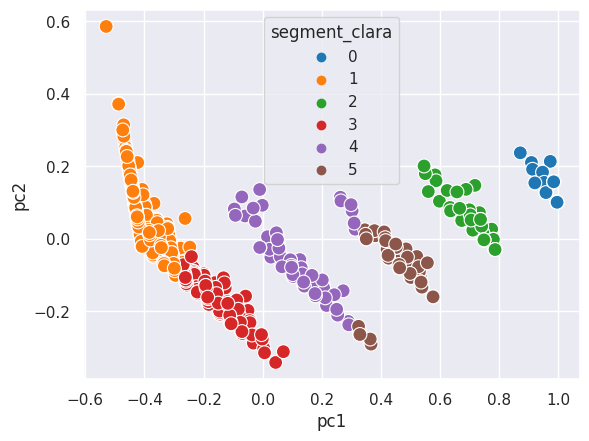

In [ ]:
sns.scatterplot(
    data=pdata,
    x = 'pc1',
    y= 'pc2',
    palette= paleta,
    hue="segment_clara",
    s= 100 )
plt.show()

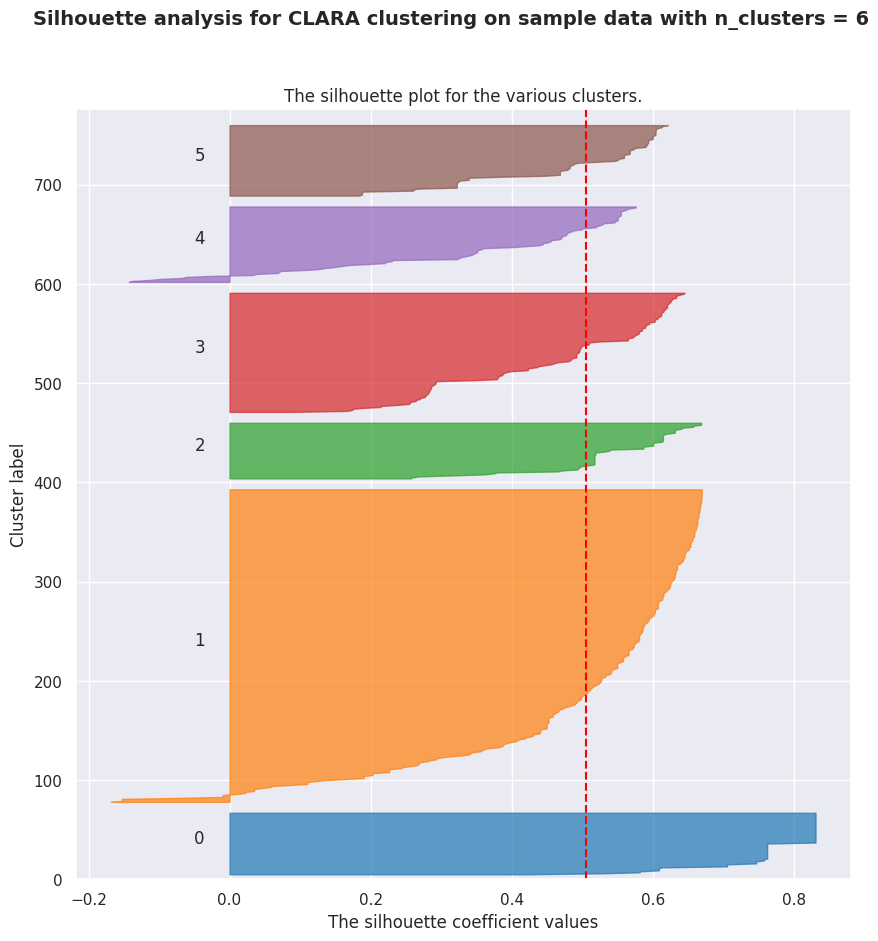

In [ ]:
visulization_silhouette(data_estandarizada, y_predict_clara_build, 'CLARA', paleta)

- El segmento uno es el más denso del resto de segmentos, cuya homogeneidad no es uniforme por su lado izquierdo en forma de cuchillo. Tiene un porcentaje de registro que es muy heterogéneo con sus pares, pero no son similares al resto de segmentos.

- El segmento cero es el más compacto, ya que supera con crece el promedio representado con la línea roja, y porque su grado de homogeneidad, se evidencia también por su forma casi rectangular.

- El segmento dos, tres, cuatro y cinco tiene un grado de homogeneidad y heterogeneidad aceptable, por lo menos las esquinas superan el promedio general, sin embargo, el grupo cuatro tiene una porción no muy homogéneo con su respectivo segmento.

# **Resultado**
---

In [ ]:
columnas

['valor_contraprestacion_promedio',
 'conteo_transacciones_totales_promedio',
 'numero_trimestres_activos',
 'ano_produccion_activo']

Para poder visualizar las gráficas de manera óptima se procede a escalar los datos a una escala logarítmica.

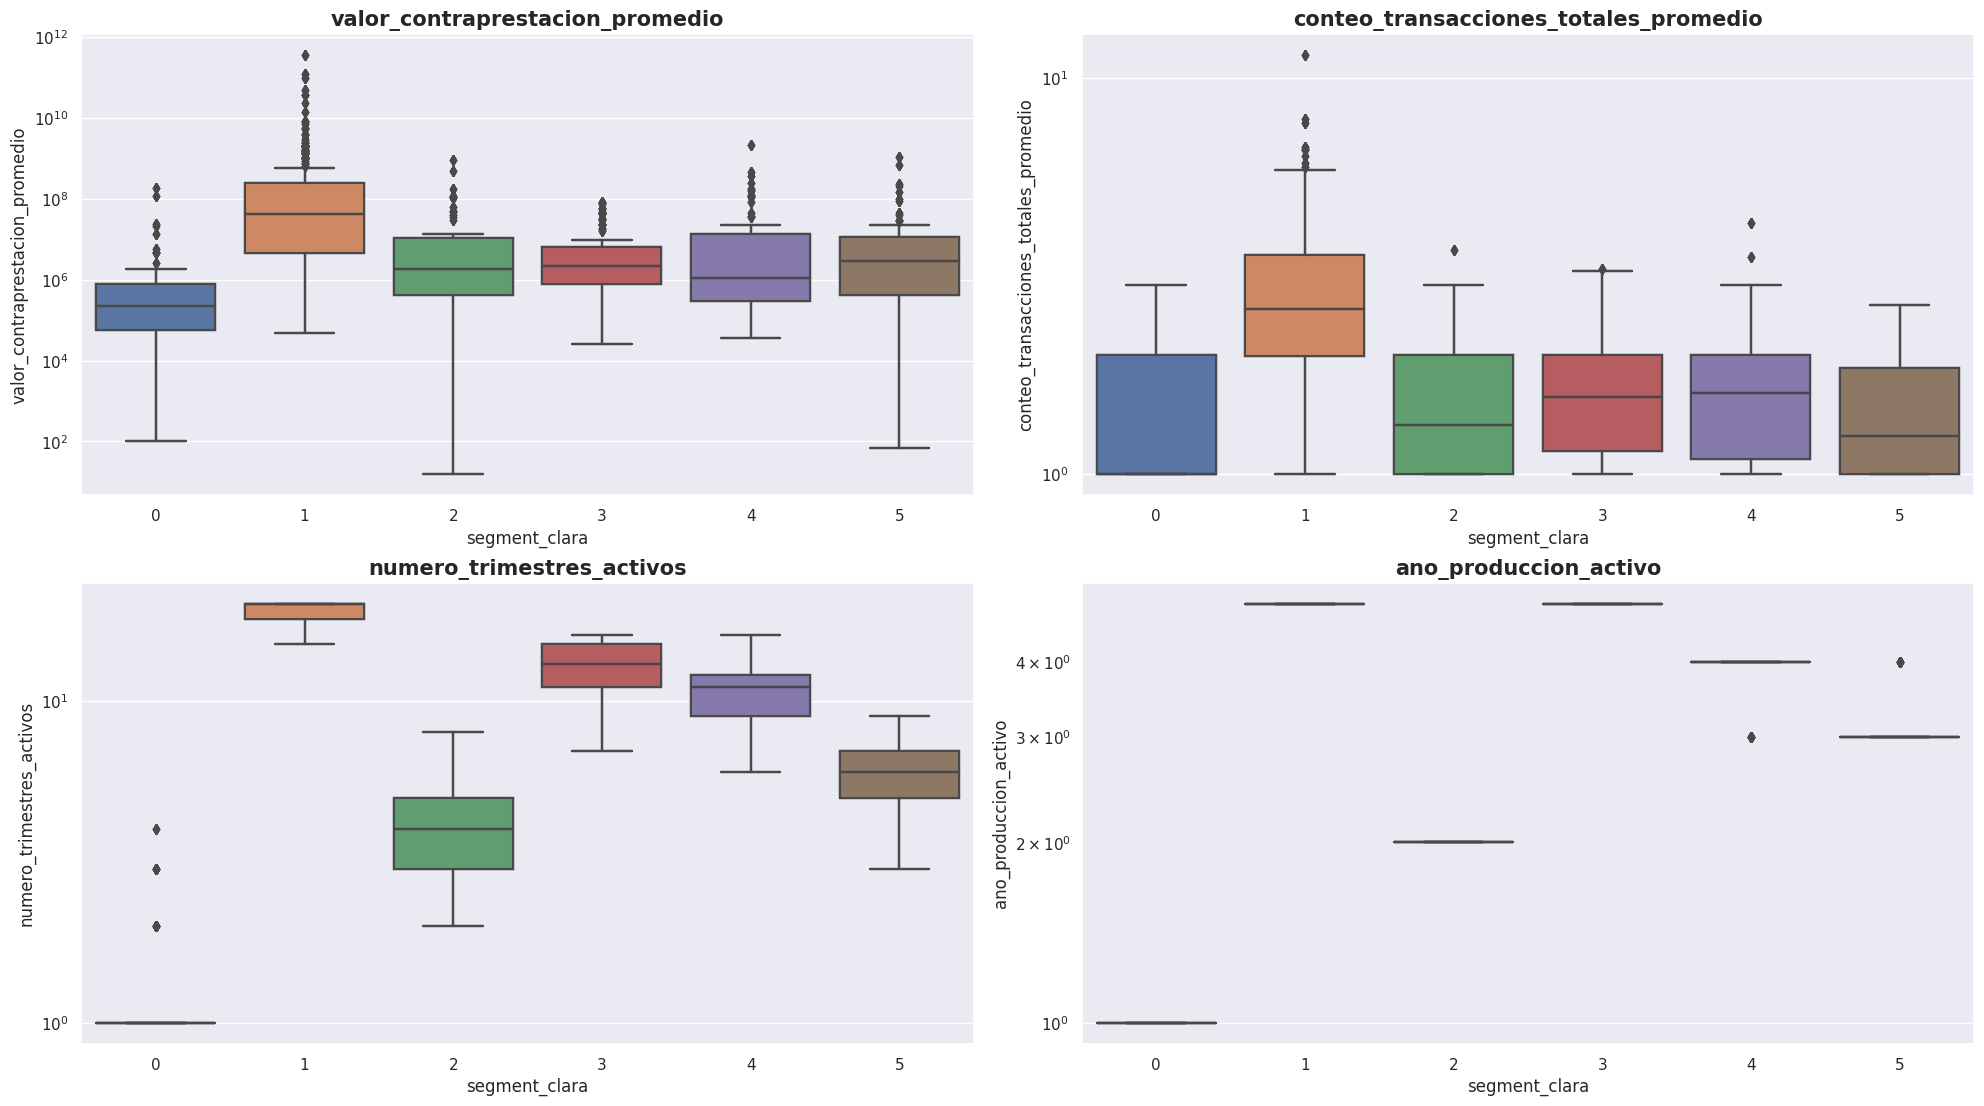

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
n, m = 0, 0
leg = []
for c in columnas:
  for j in pd.unique(data_group['segment_clara']):
    sns.boxplot(data_group, x='segment_clara', y=c, ax=axes[m, n])
    axes[m, n].set(yscale="log")
  axes[m,n].set_title(c, fontsize = 15, fontweight = "bold")
  if n == 1:
    n = -1
    m = 1

  n = n +1
fig.tight_layout()

plt.subplots_adjust(top = 0.9)

- Como se aprecia en las imágenes el año de productividad activa es una variable muy discriminatoria, pues separa de manera explícita los registros, sin embargo tal vez no sea la más importante en el modelo negocio, pues concuerda con los años seleccionados para la muestra, tal vez no sea tan idóneo seleccionarla.

- El número de meses activo es la segunda variable que mejor se comporta en la segmentación si nos basamos en la gráfica, donde el segmento con pocos valores se concentran en el segmento cero, seguido por el segmento dos y tres. Los segmentos tres y cuatro parecen tener un comportamiento con respecto a la presente variable. Por último el segmento uno es el que más concentra valores más elevados.

- La variable de conteo de transacciones promedio total no tiene una discriminación tan evidente, por lo tanto, hay un comportamiento en rangos muy similares con distribuciones distintas, por lo menos en los segmentos cero, dos, tres, cuatro y cinco. El segmento 4 es el que agrupa la mayoría de valores altos en la respectiva variable.

# **Descripción segmentos**

- El segmento cero tiene el 8.9% registros, tienen una actividad en promedio de un trimestre activo, donde realizan en promedio total aproximadamente 2 transacciones por un monto de 18,089,580.00. Por promedio teórico mensual realizan una transacción por trimestre por un monto de 6,361,731.91.

- El segmento uno tiene el 44.8% registros, tienen una actividad en promedio de 19 trimestres activos, donde realizan en promedio total aproximadamente 56 transacciones por un monto de 53,544,281,575.88. Por promedio teórico mensual realizan tres transacciones por trimestre por un monto de 2,706,158,805.79.

- El segmento dos tiene el 8.1% registros, tienen una actividad en promedio de 4 trimestres activos, donde realizan en promedio total aproximadamente 6 transacciones por un monto de 244,396,587.11. Por promedio teórico mensual realizan una transaccion por trimestre por un monto de 40,373,080.40.

- El segmento tres tiene el 17.1% registros, tienen una actividad en promedio de 13 trimestres activos, donde realizan en promedio total aproximadamente 21 transacciones por un monto de 122,858,016.01. Por promedio teórico mensual realizan dos transacciones por trimestre por un monto de 9,571,529.96.

- El segmento cuatro tiene el 11% registros, tienen una actividad en promedio de 10 trimestres activos, donde realizan en promedio total aproximadamente 18 transacciones por un monto de 563,910,091.66. Por promedio teórico mensual realizan dos transacciones por trimestre por un monto de 57,913,397.12.

- El segmento cuatro tiene el 10.2% registros, tienen una actividad en promedio de 2 trimestres activos, donde realizan en promedio total aproximadamente 9 transacciones por un monto de 239,973,432.62. Por promedio teórico mensual realizan una transaccion por trimestre por un monto de 40,740,001.93.